In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="ticks", color_codes=True)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:

abalone = pd.read_csv('abalone.csv', sep=',')

# Columns/Features

Xcolumnnames = ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']

# Categorical Column 
Xcatcolumnname = ['Sex']

# Output column
Ycolumnname = ['Rings']

abalone.columns = Xcatcolumnname + Xcolumnnames + Ycolumnname

In [3]:
abalone.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
1,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
2,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
3,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
4,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8


In [4]:
rand_state = 27 
trainsize = 0.8 
testsize = 0.2 
X = abalone[Xcolumnnames]
Y = abalone[Ycolumnname]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = testsize, random_state = rand_state)

# Storing the original train and test data to be used for ablation study later on

X_train_1 = X_train
X_test_1 = X_test


# Normalization
Normalize the data using MinMaxScaler to get the range of values in the original data to a scale between 0 to 1, thus simplifying the calculations for the model further.

In [5]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train)
X_train = min_max_scaler.transform(X_train)
X_test = min_max_scaler.transform(X_test)

In [6]:
accuracy_list = [] 
kmax = 101 
kstep = 1 
k_range = range(1, kmax, kstep)

for i in k_range:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracy_list.append(acc)
    best_acc = max(accuracy_list)
    best_k = accuracy_list.index(best_acc)+1 
 

Text(0, 0.5, 'Accuracy')

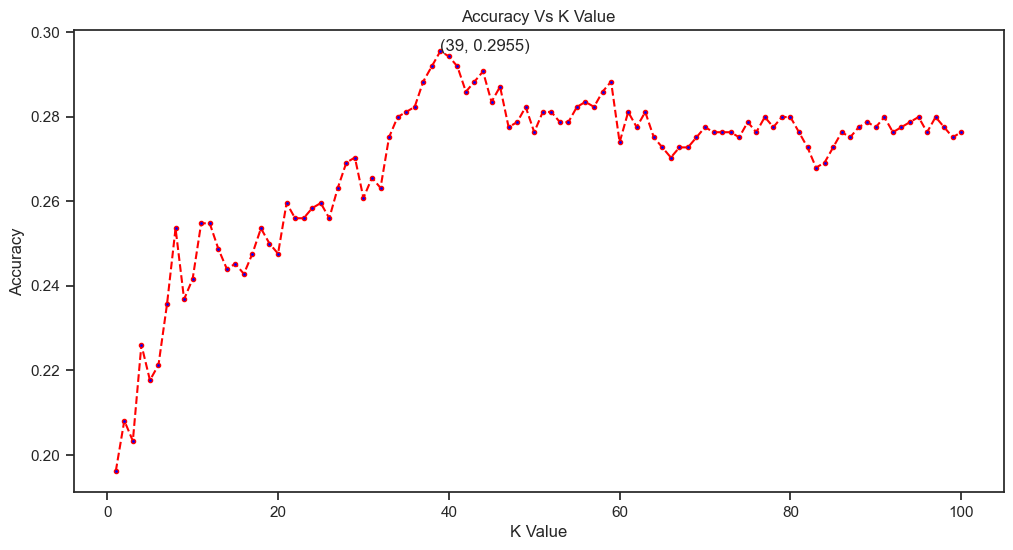

In [7]:
fig, ax = plt.subplots(figsize=(12,6))
text = '('+ str(best_k) + ', ' + str(round(best_acc, 4)) + ')'
ax.plot(k_range, accuracy_list, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=3)

plt.text(best_k, best_acc, text)
plt.title("Accuracy Vs K Value")
plt.xlabel('K Value')
plt.ylabel('Accuracy')

From the figure, it is seen that the best value of accuracy occurs at K=39 which is 0.2955

# Improving KNN
Using weighted KNN for improving our results. 3 weighing schemes are used - Default, Manhatten and Euclidean

Default: p=2, weights = uniform
Manhatten: p=1, weights = distance
Euclidean: p=2, weights = distance

where P = Power parameter for the Minkowski metric

In [10]:
acc_list_default = [] 
acc_list_manh = []
acc_list_eucl = [] 

for i in k_range:
    knn_default = KNeighborsClassifier(n_neighbors=i, p=2, weights="uniform")
    knn_manh = KNeighborsClassifier(n_neighbors=i, p=1, weights="distance")
    # Euclidean
    knn_eucl = KNeighborsClassifier(n_neighbors=i, p=2, weights="distance")
    
    knn_default.fit(X_train, y_train)
    knn_manh.fit(X_train, y_train)
    knn_eucl.fit(X_train, y_train)
    
    y_pred_default = knn_default.predict(X_test)
    y_pred_manh = knn_manh.predict(X_test)
    y_pred_eucl = knn_eucl.predict(X_test)

    acc_default = accuracy_score(y_test, y_pred_default)
    acc_manh = accuracy_score(y_test, y_pred_manh)
    acc_eucl = accuracy_score(y_test, y_pred_eucl)
    
    acc_list_default.append(acc_default)
    acc_list_manh.append(acc_manh)
    acc_list_eucl.append(acc_eucl)
    
    b1 = max(acc_list_default)
    b2 = max(acc_list_manh)
    b3 = max(acc_list_eucl)
    
    best_acc = max([b1, b2, b3])
    result = b1 
    best_k = acc_list_default.index(b1)+1 
    if b2 > result:
        result = b2 
        best_k = acc_list_manh.index(b2)+1 
    if b3 > result:
        result = b3
        best_k = acc_list_eucl.index(b3)+1 
        
        

Plot the above accuracies against the K values for all the three configurations (With normalization)

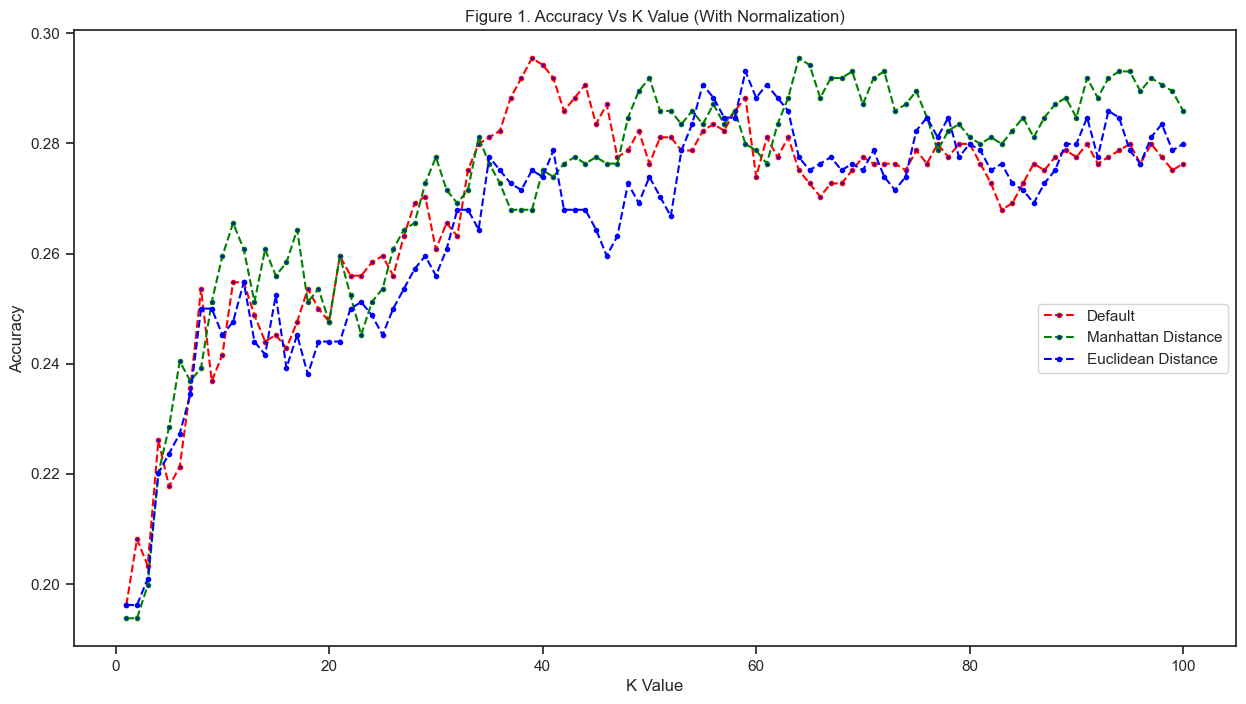

In [11]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(k_range, acc_list_default, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=3)
ax.plot(k_range, acc_list_manh, color='green', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=3)
ax.plot(k_range, acc_list_eucl, color='blue', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=3)

plt.title("Figure 1. Accuracy Vs K Value (With Normalization)")
plt.xlabel('K Value')
plt.ylabel('Accuracy')

# ax.spines['left'].set_position(('data', 1))
ax.legend(['Default', 'Manhattan Distance', 'Euclidean Distance'], loc="center right")

# Ablation Study on Normalization
Performing Ablation study by removing the normalization step from the pipeline of preprocessing.

In [12]:
# Calculating accuracy for K values between 1 and 40 (without normalization)
acc_list_abl_default = []
acc_list_abl_manh = []
acc_list_abl_eucl = []


for i in k_range:
    # Default
    knn_default = KNeighborsClassifier(n_neighbors=i, p=2, weights="uniform")
    # Manhatten
    knn_manh = KNeighborsClassifier(n_neighbors=i, p=1, weights="distance")
    # Euclidean
    knn_eucl = KNeighborsClassifier(n_neighbors=i, p=2, weights="distance")

    knn_default.fit(X_train_1, y_train)
    knn_manh.fit(X_train_1, y_train)
    knn_eucl.fit(X_train_1, y_train)

    y_pred_default = knn_default.predict(X_test_1)
    y_pred_manh = knn_manh.predict(X_test_1)
    y_pred_eucl = knn_eucl.predict(X_test_1)

    acc_default = accuracy_score(y_test, y_pred_default)
    acc_manh = accuracy_score(y_test, y_pred_manh)
    acc_eucl = accuracy_score(y_test, y_pred_eucl)
    
    acc_list_abl_default.append(acc_default)
    acc_list_abl_manh.append(acc_manh)
    acc_list_abl_eucl.append(acc_eucl)


# Finding best accuracy
c1 = max(acc_list_abl_default)
c2 = max(acc_list_abl_manh)
c3 = max(acc_list_abl_eucl)

best_acc_abl = max([c1, c2, c3])

result_abl = c1
best_k_abl = acc_list_abl_default.index(c1)+1
if c2 > result:
  result = c2
  best_k_abl = acc_list_abl_manh.index(c2)+1
if c3 > result:
  result = c3
  best_k_abl = acc_list_abl_eucl.index(c3)+1
     

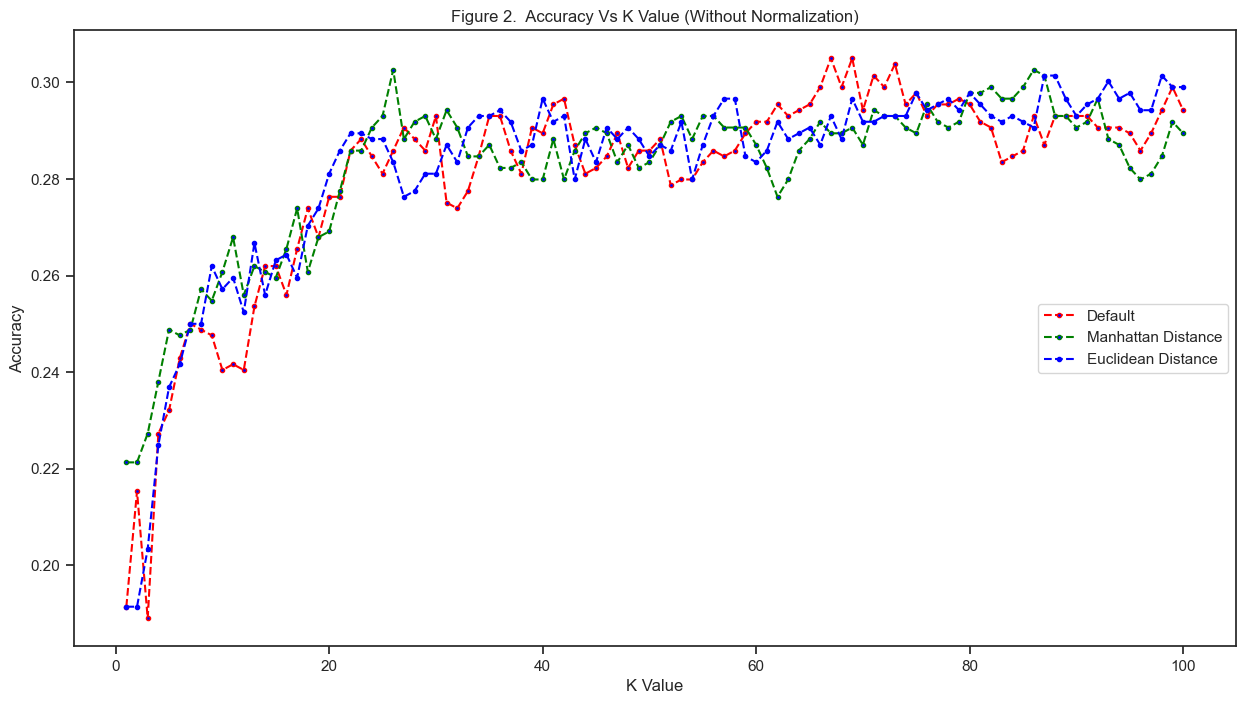

In [13]:
fig, ax = plt.subplots(figsize=(15,8))

ax.plot(k_range, acc_list_abl_default, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=3)
ax.plot(k_range, acc_list_abl_manh, color='green', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=3)
ax.plot(k_range, acc_list_abl_eucl, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=3)

plt.title("Figure 2.  Accuracy Vs K Value (Without Normalization)")
plt.xlabel('K Value')
plt.ylabel('Accuracy')

# ax.spines['left'].set_position(('data', 1))
ax.legend(['Default', 'Manhattan Distance', 'Euclidean Distance'], loc="center right")

# Conclusion
Comparing the two previous plots in Figure 1 and Figure 2, the following is observed:

Effect of normalization/ Standardization - The normalizarion does not make the classifier reach high accuracy for any of the tested values of k. This is applicable to both uniform KNN and weighted KNN.
Without the normalization, as k increases and the neighbourhood size inresases, the performance lowers. This is not observed in the case of normalized data.
For the differenct weighting schemes, the performance is not very different.
The accuracy is overall low (below 30%). Hence it can be said that more complex models might be needed to classify well in this domain.